# Download dataset from kaggle to Google Collab

Step 1 - install library kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bluezzet","key":"096247e1a871109145161c8f3c966062"}'}

In [ ]:
!pip install -q kaggle

Step 2 - membuat directory

In [3]:
!mkdir -p ~/.kaggle

Step 3 - menduplikat file kaggle.json ke directory

In [4]:
!cp kaggle.json ~/.kaggle

Step 4 - mengatur agar hak untuk mengakses file ini hanya bisa dibaca dan ditulis oleh pemiliknya saja menggunakan perintah chmod

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

Step 5 - download dataset dari kaggle

In [6]:
!kaggle datasets download -d 'lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.09GB/s]


Step 6 - unzip filenya

In [7]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


# Import library



*   os, io, dan string - Library umum untuk membaca file dan mengatur teks.
*   tqdm - Menampilkan progress bar di terminalnya dan berguna pada saat ngeload data banyak karena bisa dipantau sudah sampai mana load data yang berjalan.


*   sns - untuk visualisasi




*   BeautifulSoap - membersihkan teks dari tag HTML.
*   pd dan np - membaca dan mengatur data.

*   nltk dan stopwrods - memproses kata-kata/string dari isi review.
*   train_test_split - Bagi data jadi data latih dan data uji.


*   tf, keras, Tokenizer, dan pad_sequences - Untuk ngebangun model deep learningnya pake tensorflow dan keras.
*   plt dan WordCloud - Untuk nampilin visualisasi dan grafik.









In [8]:
import os
import io
import string
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [9]:
os.makedirs("picofwordcloud", exist_ok=True)

# Read data

Membaca file dataset yang sebelumnya sudah di download  dan berisi review dan label sentimentnya.

In [10]:
data = pd.read_csv('IMDB Dataset.csv')

Menampilkan 5 data teratas untuk memastikan data berhasil dibaca

In [11]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Convert sentiment column to int

Mengubah label sentiment yang awalnya berupa teks diubah menjadi angka dan diwakilkan oleh 0 sebagai negatif dan 1 sebagai positif.

In [12]:
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Visualize sentiment distribution

Di bagian ini kita lihat berapa banyak review yang positif dan berapa yang negatif.
Biar tahu apakah datanya seimbang atau malah lebih banyak yang positif/negatif.

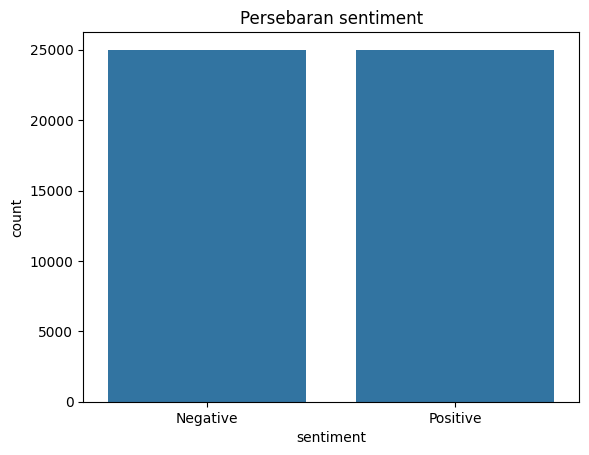

In [13]:
#Grafik untuk nunjukkin persebaran antara sentiment positif atau negatif
sns.countplot(x='sentiment', data=data)
plt.title('Persebaran sentiment')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

**Berdasarkan grafik terlihat bahwa sentiment positif dan negatif memiliki persebaran yang merata.**

# Analyze Review  Lengths

Di sini kita hitung ada berapa kata di tiap review, terus ditampilin grafiknya supaya kita bisa lihat rata-rata panjang review, mana yang pendek, mana yang panjang, dan sebarannya kayak gimana.

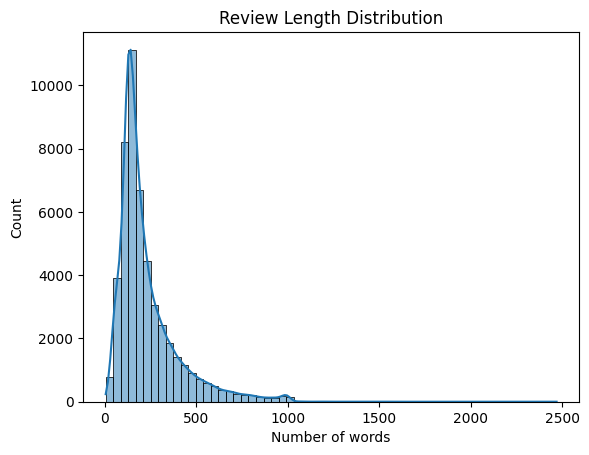

In [14]:
#Menghitung berapa banyak jumlah kata dalam setiap reviewnya
data['review_length'] = data['review'].apply(lambda x: len(x.split()))

#Nampilin statitik dasar panjang reviewnya
data['review_length'].describe()

#Ngevisualisasiin panjang reviewnya pake plt
sns.histplot(data['review_length'], bins=60, kde=True)
plt.title('Review Length Distribution')
plt.xlabel('Number of words')
plt.show()

# Review length statistics

Bagian ini nunjukin angka-angka penting dari jumlah kata di tiap review, seperti:


*   Rata-rata panjang review
*   Panjang paling pendek dan yang paling panjang
*   Sebaran panjang isi dari review secara umum








In [15]:
#Untuk ngeliat detail dari kata-katanya
data.review_length.describe()

,review_length
count,50000.000000
mean,231.156940
std,171.343997
min,4.000000
25%,126.000000
50%,173.000000
75%,280.000000
max,2470.000000


# Split data

Sebelum data dipakai untuk melatih model, urutannya diacak dulu supaya hasilnya lebih adil dan nggak bias (misalnya semua review positif ngumpul di awal ataupun sebaliknya). Setelah itu, nantinya data akan dibagi jadi dua, seperti;   

*   80% data latih - ini untuk ngetraining datanya.
*   20% data uji - ini untuk nguji ataupun ngelakuin testing ke datanya.

Kemudian data ditampilkan dan dipisahkan antara column review dan sentiment diwakilkan oleh variabel x dan y, tujuannya agar model tau bagian yang harus dianalisis, dan mana yang jadi target jawabannya.

In [16]:
#Ngacak column review sama sentimentnya
shuffled_data = data.sample(frac=1, random_state=2023)

train_size = 0.8
train_data, test_data = train_test_split(shuffled_data, train_size=train_size, random_state=2023)

In [17]:
print(f'Train shappe: {train_data.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 3)
Test shappe: (10000, 3)


In [18]:
X_train = train_data['review']
y_train = train_data['sentiment']

X_test = test_data['review']
y_test = test_data['sentiment']

# Preprocessing - clean text

Sebelum data dimasukkan ke model, teks review perlu dibersihkan dulu biar lebih rapi dan gampang dipahami oleh komputer. Nah yang dibersiin itu seperti ini.
1.   Buang kata-kata umum (stopwords)
Contohnya kayak: is, the, in, dll. Kata-kata ini nggak ngasih banyak informasi penting buat model.
2.  Semua tanda baca lain dihapus total (misalnya: !, ?, ") karena biasanya nggak ngaruh ke makna utama.
3.   Pisahin tanda baca tertentu.Misalnya , . - / dipisah dari kata supaya nggak nempel (contoh: good, jadi good ,).
4.   Hapus tag HTML
Ada beberapa review yang isinya masih ada <br> atau tag lain, ini dibersihkan pakai BeautifulSoup.
5.    Ubah ke huruf kecil semua
Supaya kata kayak “Bad” dan “bad” dianggap sama saje.
6.   Gabungkan kata yang sudah bersih ke kalimat baru.

Hasil akhirnya nantii adalah versi teks yang lebih sederhana dan siap diproses.



In [19]:
#pake stopwords untuk nltk bahasanya bahasa inggris
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
#untuk ngilangin semua tanda baca

table = str.maketrans('', '', string.punctuation)

In [21]:
X_train_cleaned = []

for item in tqdm(X_train):
    #untuk huruf kecil semua
    sentence = str(item).lower()
    # untuk tanda yang nyambung2
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    # ngapus tag html
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    # nahh ini ngapus kata yang nda terlalu relavan dan ngapus tanda baca
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table) # remove all punctuations
        if word not in stop_words:
            filtered_sentence += word + ' '

    X_train_cleaned.append(filtered_sentence.strip())

100%|██████████| 40000/40000 [00:27<00:00, 1461.97it/s]


# See sentences length distribution

Setelah semua review dibersihkan (proses diatas a.k.a preprocessing), selanjutnya adalah ngecek lagi seberapa panjang tiap kalimatnya.

Langkah-langkahnya:
*   Hitung jumlah kata di tiap kalimat bersih (X_train_cleaned).
*   Urutin panjangnya dari yang paling pendek ke paling panjang.
*   Tampilkan grafik garis untuk nunjukin sebaran panjang kalimat dari seluruh review.

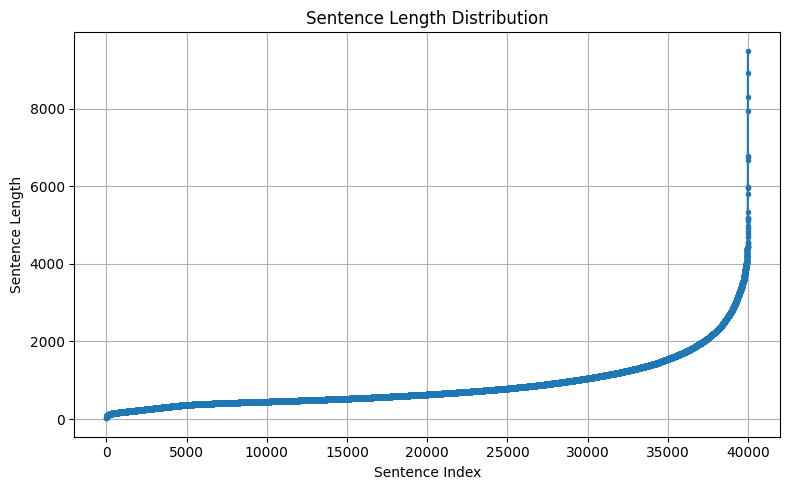

In [22]:
sentence_lengths = [len(sentence) for sentence in X_train_cleaned]
sorted_lengths = sorted(sentence_lengths)

x_values = list(range(1, len(X_train_cleaned) + 1))

plt.figure(figsize=(8, 5))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.show()

Grafik yang bawah ini nunjukin panjang setiap review setelah dibersihkan, dari yang paling pendek ke paling panjang.
Tapi kali ini dibatasi sumbu Y sampai 3000 kata ajaa, supaya review yang terlalu panjang gak bikin grafik jadi susah dibaca.

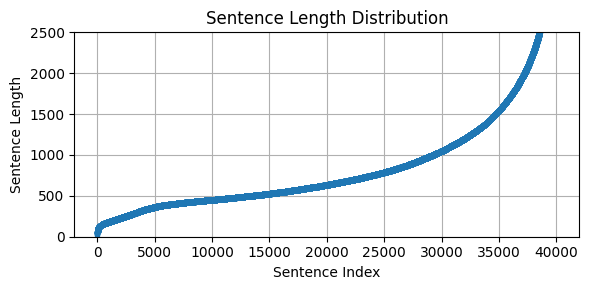

In [23]:
plt.figure(figsize=(6, 3))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 2500)
plt.show()

**Berdasarkan grafik tersebut terlihat bahwa sebagian besar kalimat dari review yang ada memiliki kurang dari 2000 kata dan 1000 kata.**

In [24]:
X_train.describe()

,review
count,40000
unique,39726
top,Loved today's show!!! It was a variety and not...
freq,5


In [25]:
all_reviews = pd.concat([X_train, X_test])
review_lengths = all_reviews.apply(lambda x: len(str(x).split()))
print(review_lengths.describe())

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review, dtype: float64


# Check the total set of words

Pada bagian ini, semua kata yang muncul pada semua review yang telah di clean tadi akan dikumpulkan dan dihitung ada berapa jumlahnya.

In [26]:
all_words = [word for sentence in X_train_cleaned for word in sentence.split()]

# Calculate the vocabulary size (number of unique words)
total_vocab_size = len(set(all_words))

print("Total Vocabulary Size:", total_vocab_size)

Total Vocabulary Size: 110111


**Artinya, ada 110.111 kata unik di seluruh data training tersebut.**

# Tokenization

Selanjutnya, setelah semua kalimat dari review dibersihkan, diubahlah teks-teks tersebut menjadi angka agar lebih mudah dibaca oleh model machine learningnya, nah proses tersebut disebut Tokenization. Untuk tahapannya itu sendiri berupa;
1.   Inisialisasi Tokenizer - buat tokenizer dengan *vocab_size* untuk ngambil 50.000 kata teratas dan *oov_tok* untuk kata yang ga dikenal
2.   Ngelatih Tokenizer dengan data - nantinya Tokenizer membaca seluruh data teks dan menyusun daftar kata.
3.   Ngeubah teks jadi angka - Setiap kalimat diubah jadi deretan angka sesuai daftar kata yang sudah dibuat.
4.   Nyamain panjang kalimat
5.   Pake untuk data testing juga.



In [27]:
#disini bagian ngebuat parameternya

#untuk step 1 - membatasi sampe 50.000 angka saja
vocab_size = 50000

#untuk step 4
max_length = 2000
trunc_type='post'
padding_type='post'

#untuk step 1
oov_tok = ""

In [28]:
#ini bagian inisialisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

#ini untuk ngelatin tokenizernya
tokenizer.fit_on_texts(X_train_cleaned)

In [29]:
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# WordCloud

Di bagian ini,  dibikin gambar Word Cloud buat nunjukkin kata-kata apa aja yang paling sering muncul di data review.


*   Diambillah daftar kata dari tokenizer yang udah dilatih sebelumnya (tokenizer.word_counts).
*   Kata yang sering muncul bakal ditampilkan makin besar di gambar Word Cloud.
*   Gambarnya juga kita simpan ke file dengan nama header.png, biar bisa dipakai lagi nanti.

Setelah itu, kita tampilkan hasil Word Cloud-nya pakai matplotlib dehh.

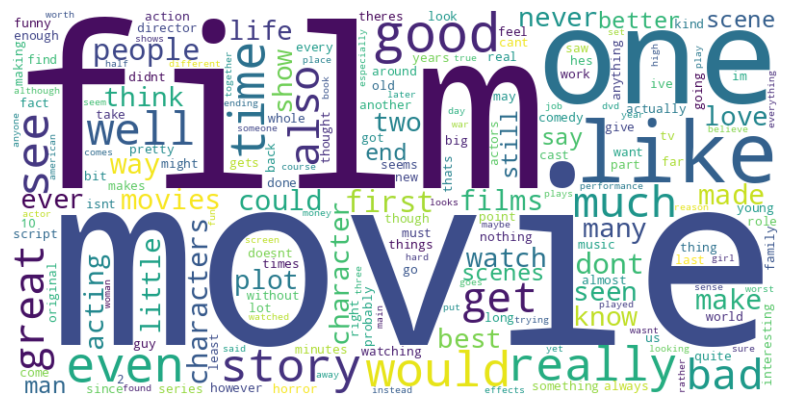

In [30]:
wordcloud = WordCloud(width=800, height=400, background_color='white')

word_counts = tokenizer.word_counts
wordcloud.generate_from_frequencies(word_counts)
wordcloud.to_file("picofwordcloud/header.png")

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [31]:
print("Panjang word index:", len(tokenizer.word_index))
print("Contoh isi word index:")
for word, index in list(tokenizer.word_index.items())[:10]:
    print(f"{word}: {index}")

Panjang word index: 110112
Contoh isi word index:
: 1
movie: 2
film: 3
one: 4
like: 5
good: 6
time: 7
even: 8
would: 9
really: 10


# Split Data Train dan Validation

In [32]:
training_padded, validation_padded, y_train, y_valid = train_test_split(training_padded, y_train, test_size=0.2, random_state=2023)

In [33]:
training_padded = np.array(training_padded)
validation_padded = np.array(validation_padded)
testing_padded = np.array(testing_padded)

training_labels = np.array(y_train).astype(np.int32)
validation_labels = np.array(y_valid).astype(np.int32)
testing_labels = np.array(y_test).astype(np.int32)

In [34]:
print("Train:", training_padded.shape, training_labels.shape)
print("Valid:", validation_padded.shape, validation_labels.shape)
print("Test :", testing_padded.shape, testing_labels.shape)
print("Unique labels train:", np.unique(training_labels, return_counts=True))

Train: (32000, 2000) (32000,)
Valid: (8000, 2000) (8000,)
Test : (10000, 2000) (10000,)
Unique labels train: (array([0, 1], dtype=int32), array([15978, 16022]))


# Neural Network

In [35]:
#tf.keras.backend.clear_session()
#model = tf.keras.Sequential()

In [36]:
# Param konfigurasi
embedding_dim = 64
l2_regularization = 0.001
input_length = training_padded.shape[1]

In [37]:
def create_model(vocab_size, embedding_dim, input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim,
                                  input_length=input_length),
        tf.keras.layers.SpatialDropout1D(0.2),  # NEW: bantu regularisasi di embedding

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),

        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.5),  # ditingkatkan dropout

        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.4),  # ditingkatkan dropout

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [38]:
# Buat model
model = create_model(vocab_size, embedding_dim, input_length)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
checkpoint_path = "training/cp-{epoch:04d}.weights.h5"
checkpoint_dir = 'training'
os.makedirs(checkpoint_dir, exist_ok=True)

In [40]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq='epoch'  # setiap akhir epoch
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,              # Berhenti setelah 5x val_loss tidak membaik
                           restore_best_weights=True,
                           verbose=1)

In [ ]:
num_epochs = 100

history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    batch_size = 64,
    validation_data=(validation_padded, validation_labels),
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

Epoch 1/100


In [1]:

def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

In [ ]:
plot_history(history, "accuracy")
plot_history(history, "loss")

In [ ]:
model.evaluate(testing_padded, testing_labels, verbose=2)